In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

/Users/marskar/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
#Input data files are available in the "../input/" directory, on Kaggle and this repo.
prop = pd.read_csv("../input/properties_2016.csv", low_memory=False)

### ... check for NaNs
nan = prop.isnull().sum()/len(prop)*100

### Plotting NaN counts
nan_sorted = nan.sort_values(ascending=False).to_frame().reset_index()
nan_sorted.columns = ['Column', 'percentNaN']

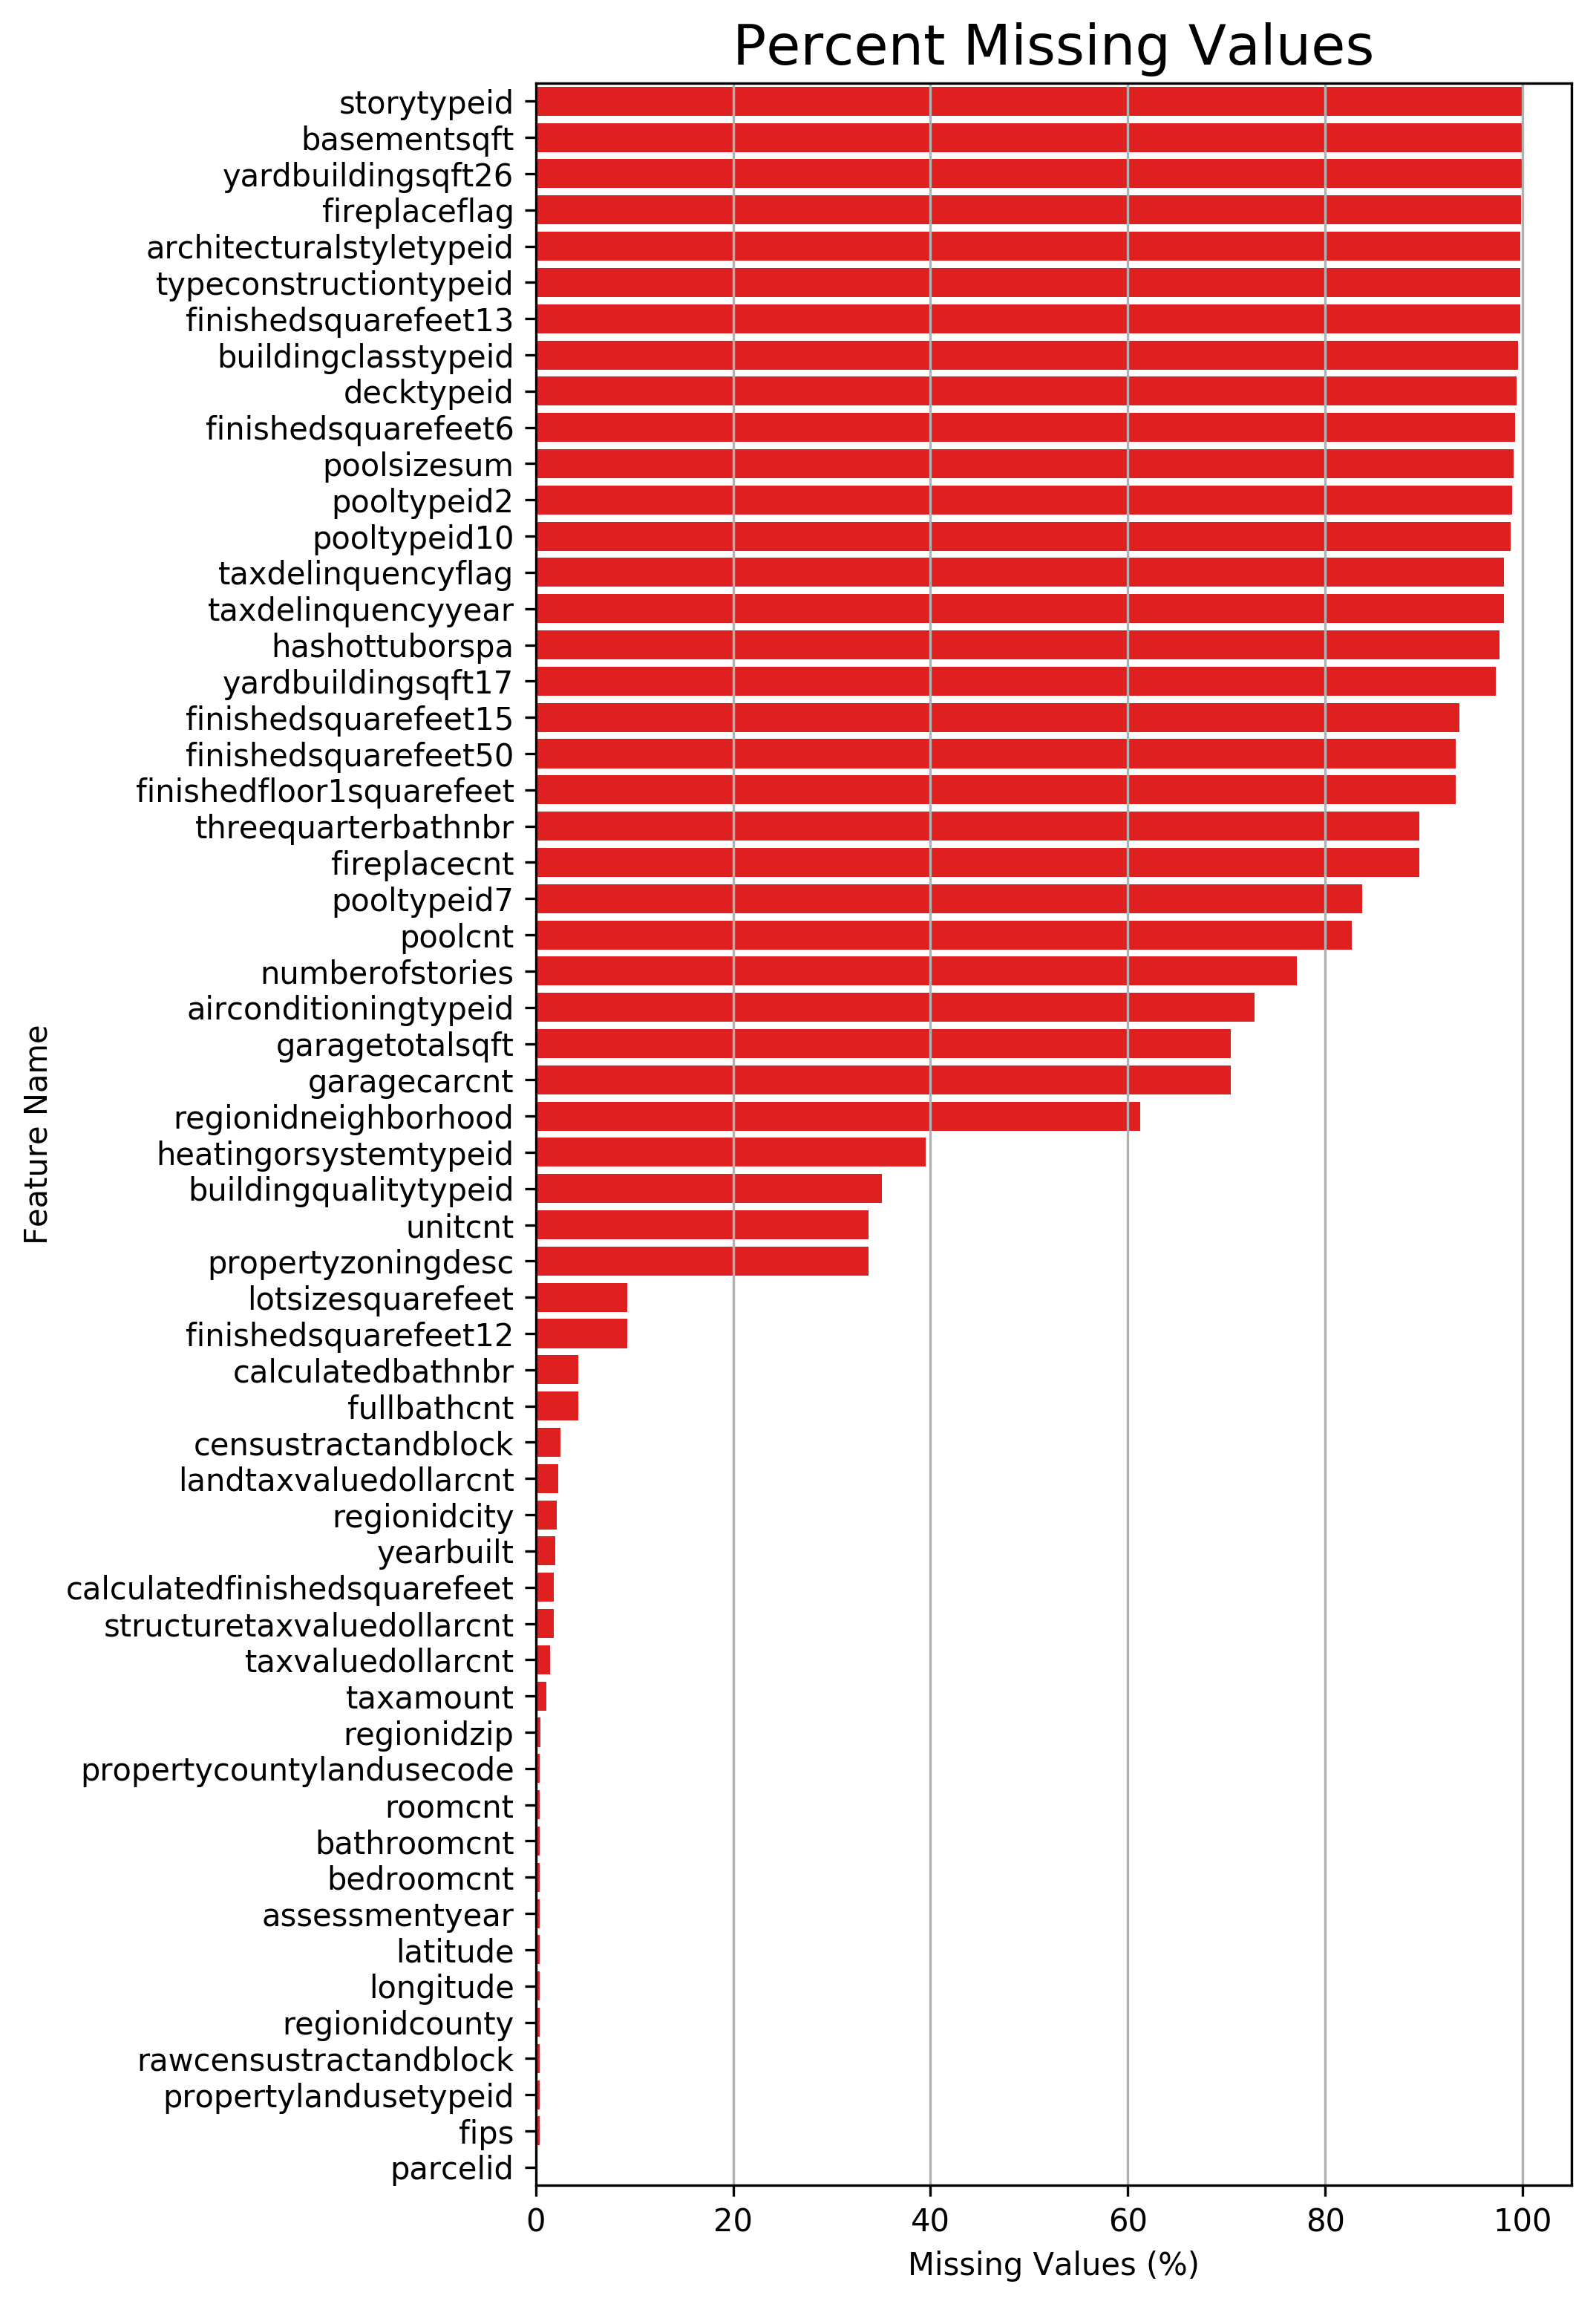

In [4]:
fig, ax = plt.subplots(figsize=(6, 12.5), dpi=300)
sns.barplot(x="percentNaN", y="Column", data=nan_sorted, color='Red', ax=ax)
ax.set(xlabel="Missing Values (%)", ylabel="Feature Name")
ax.set_title("Percent Missing Values",fontsize= 18)
ax.xaxis.grid()
plt.show()

In [5]:
train = pd.read_csv("../input/train_2016_v2.csv", parse_dates=["transactiondate"])
train['transaction_month'] = pd.DatetimeIndex(train['transactiondate']).month
train.sort_values('transaction_month', axis=0, ascending=True, inplace=True)
# Here I will merge the train and properties datasets
train = pd.merge(train, prop, on='parcelid', how='left')
# Now I will impute the missing values with median values to compute the importance scores
median_values_train = train.median(axis=0)
train = train.fillna(median_values_train, inplace=True)
for c in train[['transactiondate', 'hashottuborspa', 'propertycountylandusecode', 'propertyzoningdesc', 'fireplaceflag', 'taxdelinquencyflag']]:
    label = LabelEncoder()
    label.fit(list(train[c].values))
    train[c] = label.transform(list(train[c].values))

x_train = train.drop(['parcelid', 'logerror', 'transactiondate'], axis=1)
y_train = train['logerror']

In [6]:
etr = ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
etr.fit(x_train, y_train);

etr_importance = etr.feature_importances_
etr_importance_df = pd.DataFrame()
etr_importance_df['features'] = x_train.columns
etr_importance_df['importance'] = etr_importance
etr_importance_df.head();

etr_importance_df.sort_values('importance', axis=0, inplace=True, ascending=False)

etr_importance_df.tail(n=20)

etr_importance_df_trim = etr_importance_df[:-13]

etr_importance_df_trim.tail()

etr_feat_list = etr_importance_df_trim.features

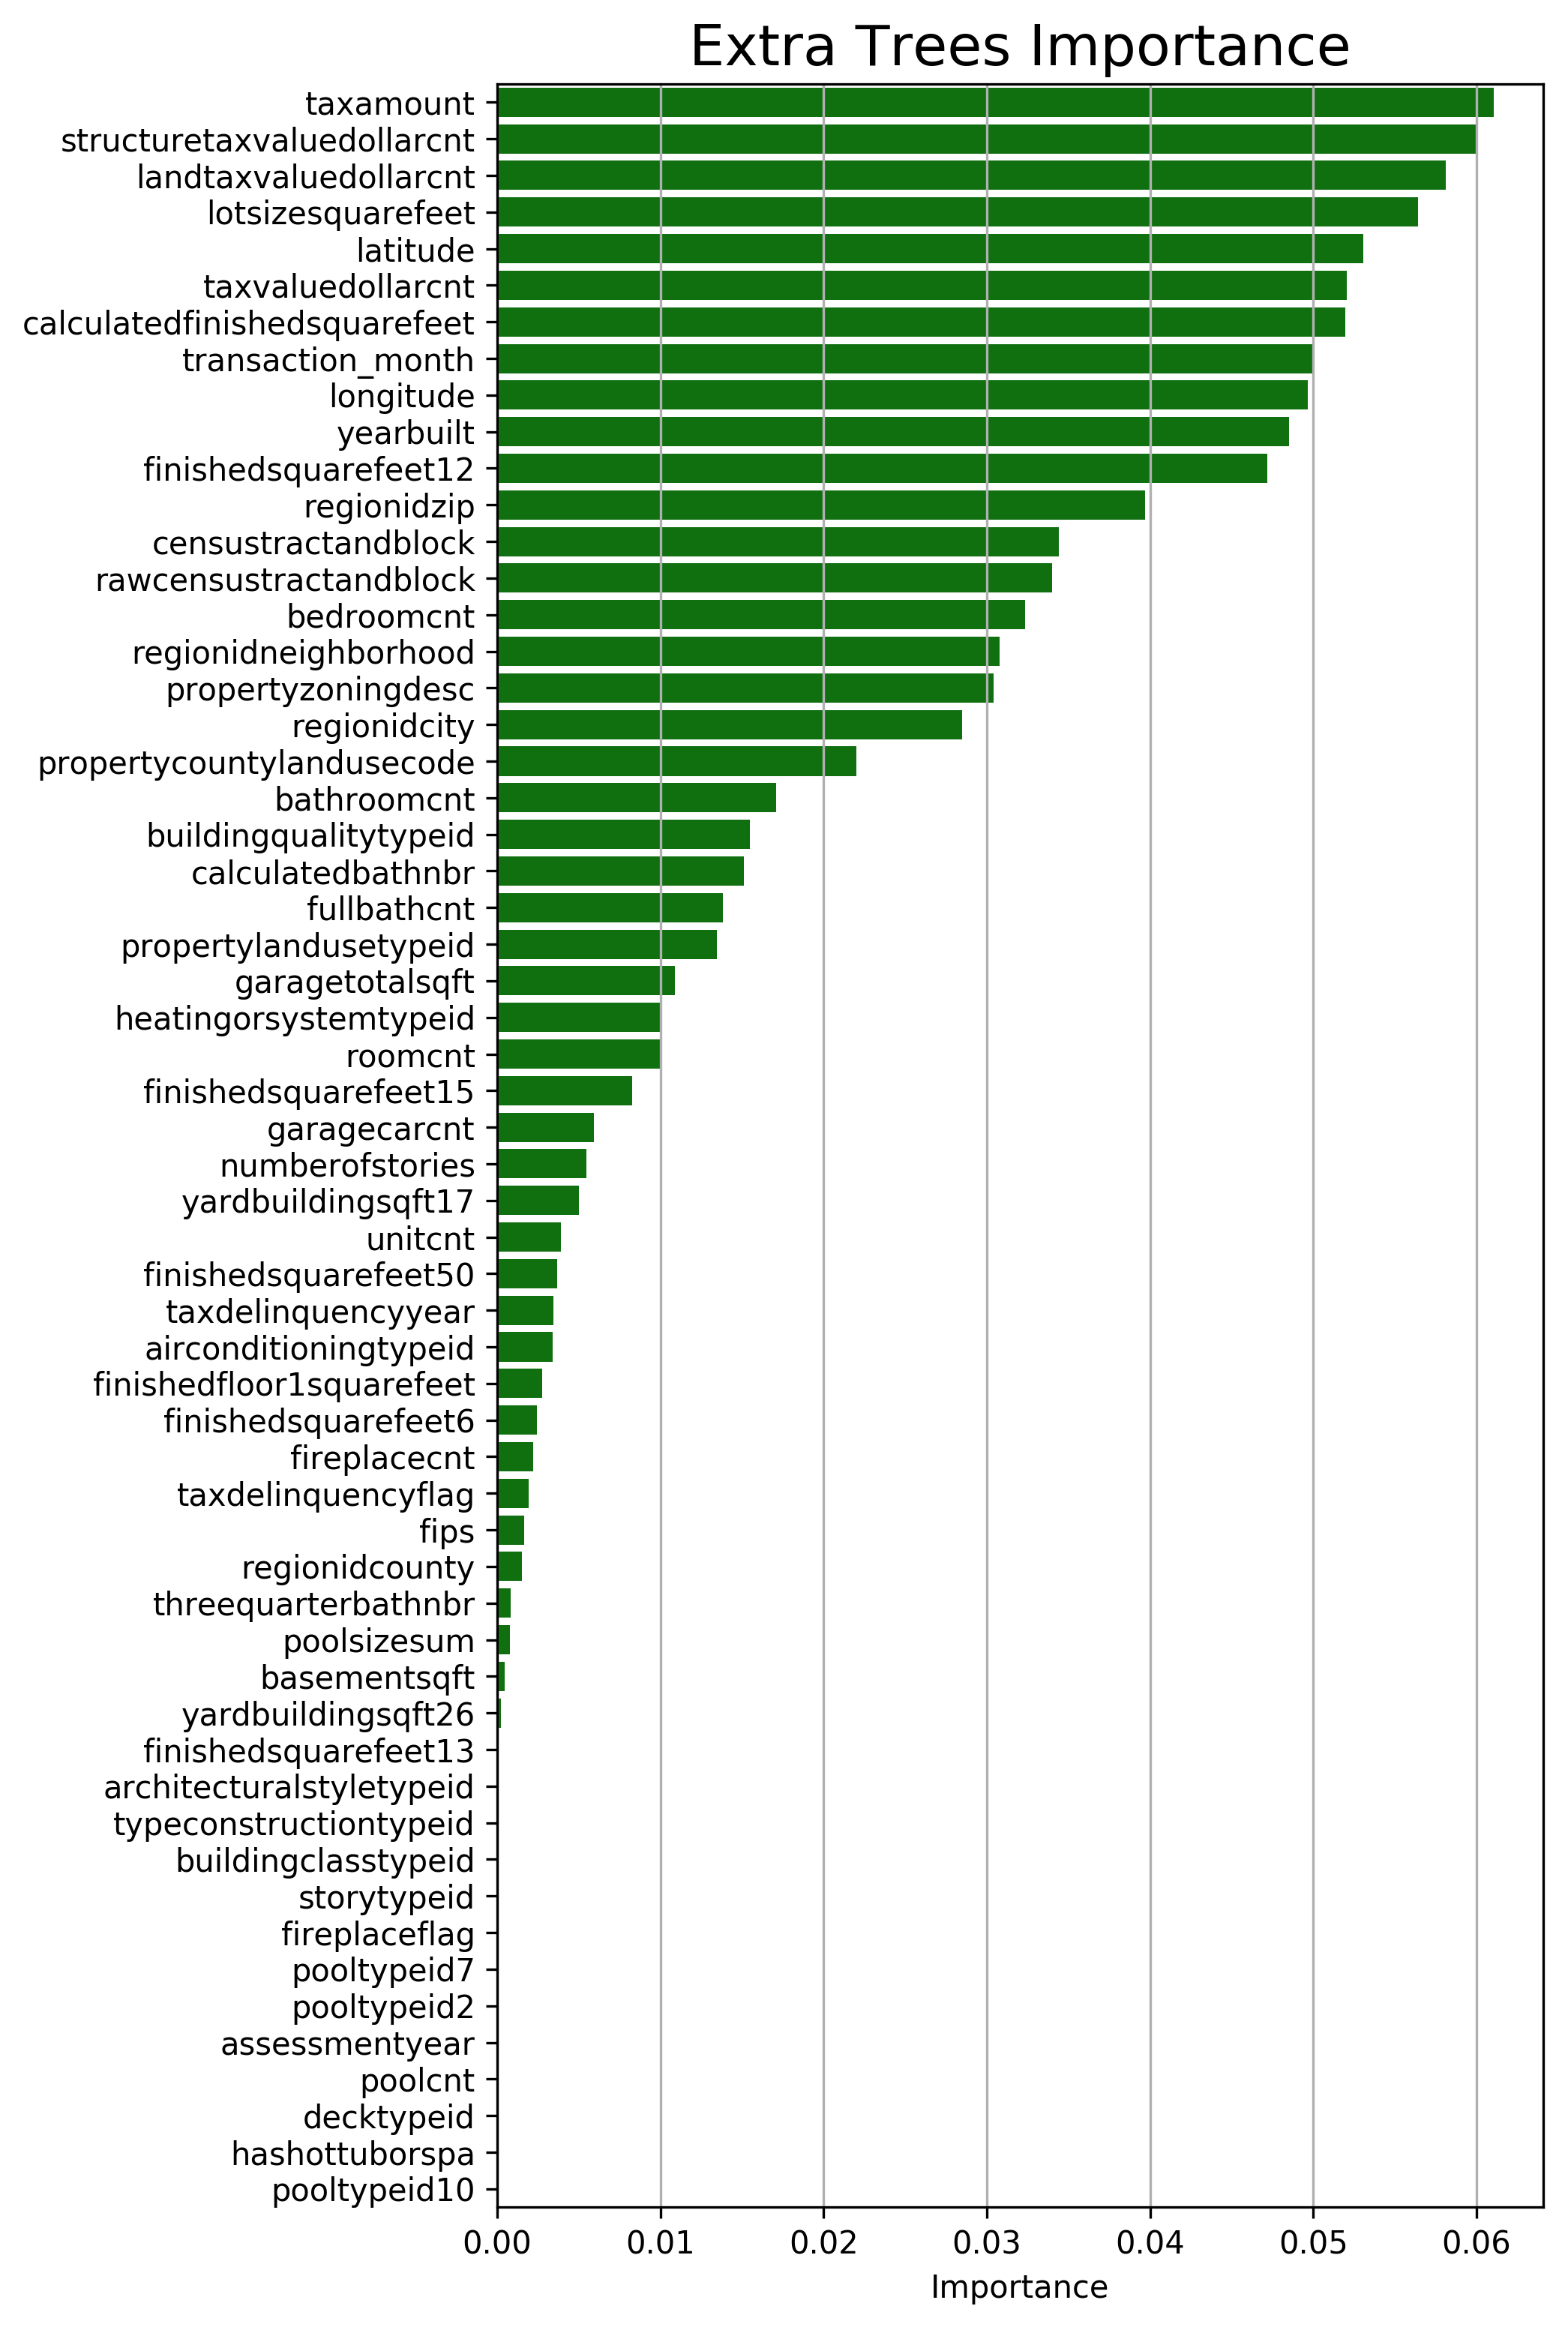

In [8]:
fig, ax = plt.subplots(figsize=(6, 12.5), dpi=300)
sns.barplot(x="importance", y="features", data=etr_importance_df, color='Green', ax=ax)
ax.set(xlabel="Importance", ylabel="")
ax.set_title('Extra Trees Importance', fontsize= 18)
ax.xaxis.grid()
plt.show()